# Inverse Engineering 3: Demosaicing Kernel Inversion

In [14]:
## Import libraries, set random seed for reproducibility, and define device and parameters
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
# include parent dir
import sys
sys.path.append('..')
from camflow import OpticalFilter, ADC, Demosaic
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device("cpu")
# Parameters
H, W = 800, 800

(1) Init + Train

In [15]:
# Ground truth demosaic kernels:
# R: pick upper-left pixel
# G: avg upper-right and bottom-left
# B: pick bottom-right
# Already defined in the Demosaic class. Let's create a GT model and input.
num_iters = 200
demosaic_gt = Demosaic().to(device)
# Freeze GT model
for p in demosaic_gt.parameters():
    p.requires_grad = False

mosaic_input = torch.rand(1, H, W)

# Get GT output
with torch.no_grad():
    demosaic_gt_out = demosaic_gt(mosaic_input)

# Now create a new demosaic model from scratch and try to recover kernels
demosaic_model = Demosaic().to(device)
# Initialize with random weights
with torch.no_grad():
    init = torch.randn_like(demosaic_model.kernel.data)
    demosaic_model.kernel.data = init.clone()

opt = optim.Adam(demosaic_model.parameters(), lr=1)
scheduler = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_iters)

losses_demosaic = []
for i in range(num_iters):
    opt.zero_grad()
    pred = demosaic_model(mosaic_input)
    loss = ((pred - demosaic_gt_out)**2).mean()
    loss.backward()
    opt.step()
    scheduler.step()
    losses_demosaic.append(loss.item())
    if (i+1) % 50 == 0:
        print(f"Iteration {i+1}, Loss: {loss.item():.6f}")

Iteration 50, Loss: 0.002033
Iteration 100, Loss: 0.000026
Iteration 150, Loss: 0.000000
Iteration 200, Loss: 0.000000


(2) Plot & Save

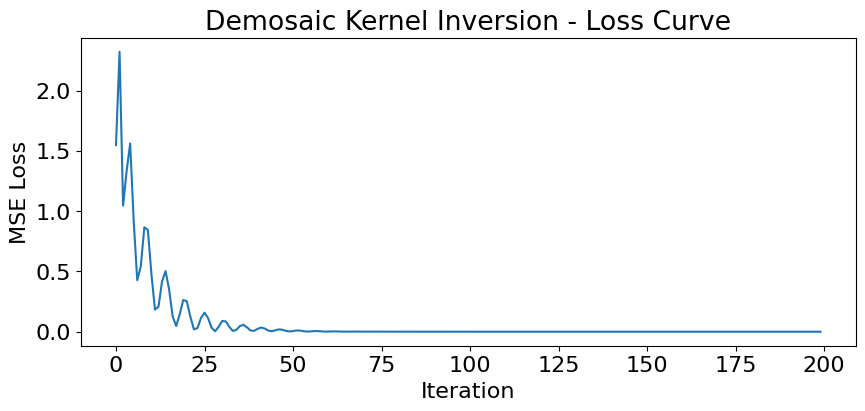

<Figure size 640x480 with 0 Axes>

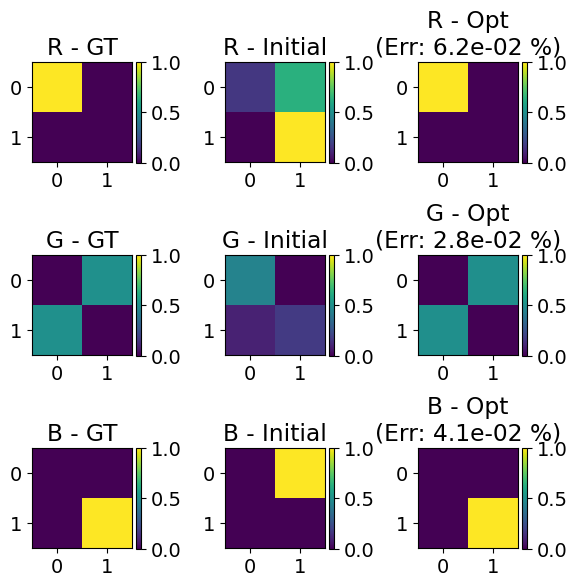

In [16]:
# mkdir dir called result if not exist
if not os.path.exists('results'):
    os.makedirs('results')

# Plot results for Demosaic Kernel Inversion
plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 16})
# set large label size to 14
plt.rcParams.update({'axes.labelsize': 16})
plt.subplot(1,1,1)
plt.plot(losses_demosaic)
plt.title("Demosaic Kernel Inversion - Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
# save the loss curve
plt.savefig("results/demosaic_loss.png")
plt.show()
plt.clf()
# Plot results for Demosaic Kernel Inversion
# plt.figure(figsize=(8, 6))

# Compare kernels
gt_kernel = demosaic_gt.kernel.detach().numpy().squeeze()    # shape: (3, 2, 2)
rec_kernel = demosaic_model.kernel.detach().numpy().squeeze() # shape: (3, 2, 2)
initial_kernel = init.detach().numpy().squeeze() # shape: (3, 2, 2)
plt.rcParams.update({'font.size': 14})
# set large label size to 14
plt.rcParams.update({'axes.labelsize': 14})
# Titles for each channel
channel_names = ['R', 'G', 'B']

plt.figure(figsize=(6, 6))  # Adjust figure size for single-row layout

for i in range(3):
    # Ground Truth
    plt.subplot(3, 3, 3*i+1)
    plt.imshow(gt_kernel[i], cmap='viridis', vmin=np.min(gt_kernel), vmax=np.max(gt_kernel))
    plt.title(f'{channel_names[i]} - GT')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.xticks([0,1])
    plt.yticks([0,1])
    
    # Initial Kernel
    plt.subplot(3, 3, 3*i+2)
    plt.imshow(initial_kernel[i], cmap='viridis', vmin=np.min(gt_kernel), vmax=np.max(gt_kernel))
    plt.title(f'{channel_names[i]} - Initial')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.xticks([0,1])
    plt.yticks([0,1])

    # Recovered Kernel
    rel_error = np.sum(np.abs(gt_kernel[i] - rec_kernel[i])) / np.sum(np.abs(gt_kernel[i])) * 100
    formatted_error = f"{rel_error:.1e}"  # Use scientific notation
    plt.subplot(3, 3, 3*i+3)
    plt.imshow(rec_kernel[i], cmap='viridis', vmin=np.min(gt_kernel), vmax=np.max(gt_kernel))
    plt.title(f'{channel_names[i]} - Opt\n(Err: {formatted_error} %)')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.xticks([0,1])
    plt.yticks([0,1])

plt.tight_layout()
# save the kernel comparison
plt.savefig("results/demosaic_kernels.png")
plt.show()
